In [1]:
import json
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

from Utilities import score
from Utilities import plot_matrix_runs, plot_results
from Utilities import number_of_neighbours, PairData

from training import training_loop

from models import GCN_pairs_distance

## Exploration of extracted homomorphism counts

In [2]:
with open('data/homomorphism_counts/MUTAG_full_kernel_max_20_run1.homson') as f:
   data_run1 = json.load(f)

with open('data/homomorphism_counts/MUTAG_full_kernel_max_20_run2.homson') as f:
   data_run2 = json.load(f)

# To extract the homomorphism counts for each of the embeddings
hom_counts_list_run1 = np.array([element['counts'] for element in data_run1['data']], dtype = 'float')
hom_counts_list_run2 = np.array([element['counts'] for element in data_run2['data']], dtype = 'float')

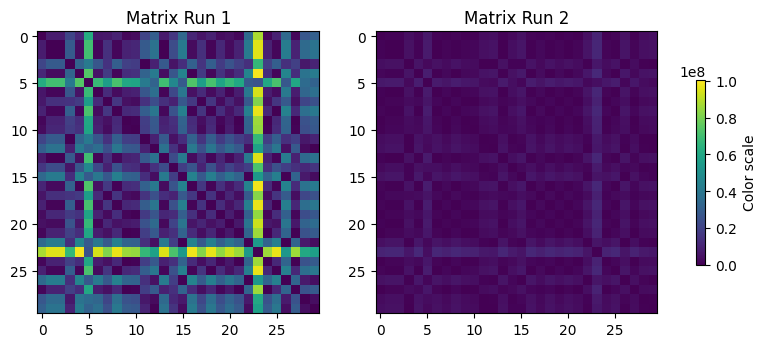

In [3]:
L1_run1 = cdist(hom_counts_list_run1, hom_counts_list_run1, metric='cityblock')
L1_run2 = cdist(hom_counts_list_run2, hom_counts_list_run2, metric='cityblock')
plot_matrix_runs(L1_run1, L1_run2, num_elements=30) # We can see some inconsitent scales among different runs

In [4]:
int((np.count_nonzero(L1_run1 == 0) - 188)/2) # There are this number of graphs which have distance 0 between themselves 

87

In [5]:
# We can avoid this issue by rescaling the output distance
hom_counts_list_run1[0] # Homomorphism count vector corresponding to the first one
# Either rescale the final y output to be in [0,1]
# Rescale the original homomorphism counts vectors so that they like sum to 1 (using something like a softmax) -> Maybe problematic cause small patterns may appear a lot of times more than lager patters

array([1.7000000e+01, 3.8000000e+01, 9.2000000e+01, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 3.4960000e+03,
       1.4433918e+07, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00])

### Try to see if GNN picks up something interesting

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
dataset = TUDataset(root='/tmp/MUTAG_transformed', name='MUTAG', pre_transform=number_of_neighbours) 

In [8]:
# Check that they are in the same order as the dataset
for i in range(len(dataset)):
    if (dataset[i]['x'].shape[0] != data_run1['data'][i]['vertices']):
        print(f"The {i}-th observation is different")
        print(dataset[i]['x'].shape[0])
        print(data_run1['data'][i]['vertices'])

In [9]:
# Now we split the dataset into training and test validation set (see if include test later)
# For now we ignore shuffling, will do it later (I know not good practice but have to map each homcount to the node)
train_dataset = dataset[:100]
val_dataset = dataset[100:]

In [10]:
# Construct all pairs of graphs using PairData object for both the training and validation set.
distance_matrix = L1_run1

train_data_list = []
for ind1, graph1 in enumerate(train_dataset):
    for ind2, graph2 in enumerate(train_dataset[ind1+1:]):
        ind2 += (ind1 + 1)
        train_data_list.append(PairData(x_1=graph1.x, edge_index_1=graph1.edge_index,
                            x_2=graph2.x, edge_index_2=graph2.edge_index,
                            distance = float(distance_matrix[ind1, ind2])).to(device))   

val_data_list = []
for ind1, graph1 in enumerate(val_dataset):
    for ind2, graph2 in enumerate(val_dataset[ind1+1:]):
        ind2 += (ind1 + 1)
        val_data_list.append(PairData(x_1=graph1.x, edge_index_1=graph1.edge_index,
                            x_2=graph2.x, edge_index_2=graph2.edge_index,
                            distance = float(distance_matrix[ind1 + len(train_dataset), ind2 + len(train_dataset)])).to(device))   

In [11]:
batch_size = 32
train_loader = DataLoader(train_data_list, batch_size=batch_size, follow_batch=['x_1', 'x_2'], shuffle=True)
val_loader = DataLoader(val_data_list, batch_size=batch_size, follow_batch=['x_1', 'x_2'], shuffle=False)
for step, data in enumerate(train_loader):
    print(f'Batch {step + 1}:')
    data = data.to(device)
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print(data.distance)
    print()
    break # Only print 1

Batch 1:
Number of graphs in the current batch: 32
PairDataBatch(x_1=[576, 1], x_1_batch=[576], x_1_ptr=[33], edge_index_1=[2, 1280], x_2=[586, 1], x_2_batch=[586], x_2_ptr=[33], edge_index_2=[2, 1304], distance=[32])
tensor([  689317., 26226974.,  3052296., 48696136., 15699133., 11768054.,
        29207294., 53407300., 10903729., 27348836., 39900200., 14021969.,
          833920.,  5160517.,  8853437., 11281325., 42008132., 48669068.,
         4428205., 15276004.,  9081138., 22162200., 23401766., 25241700.,
        53260964., 15225753., 53019568., 16986274., 33784320., 54329244.,
         2710049., 16031282.])



In [12]:
model = GCN_pairs_distance(input_features=dataset.num_node_features, hidden_channels=64, output_embeddings=300, name='GCN3_L1', dist = 'L1').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()
print(model)

GCN_pairs_distance(
  (conv1): GCNConv(1, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=300, bias=True)
  (pdist): PairwiseDistance()
)


In [13]:
training_loop(model, train_loader, optimizer, criterion, val_loader, epoch_number=10)

Epoch: 10 | Time for 10 epochs: 0m 26s
	Train Loss: 390942434924319.375
	 Val. Loss: 802954973229875.250


## Inference step

In [14]:
model = GCN_pairs_distance(input_features=dataset.num_node_features, hidden_channels=64, output_embeddings=300, name='GCN3_L1', dist='L1').to(device)
model.load_state_dict(torch.load("models/GCN3_L1.pt"))

<All keys matched successfully>

In [15]:
y, predictions = score(model, val_loader)

MSE Loss: 803609654591488.0


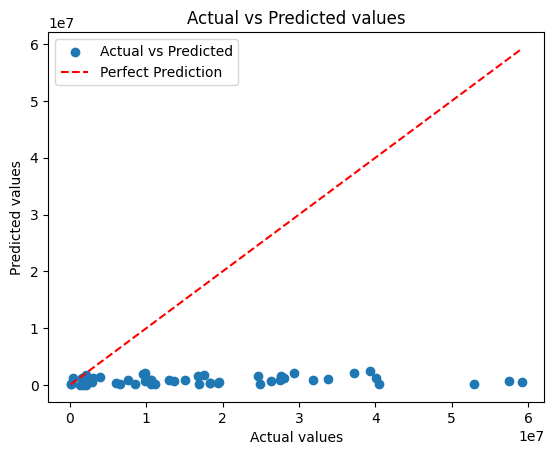

In [16]:
plot_results(y, predictions, subset=50)